# Faster R-CNN in Pytorch with Example

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import os
from PIL import Image

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms import functional as F

## Utils

In [2]:
import xml.etree.ElementTree as ET
import numpy as np
import os
import matplotlib.pyplot as pyplot
import matplotlib.patches as patches
from tqdm import tqdm

import torch
from torchvision import ops
import torch.nn.functional as F
import torch.optim as optim

# -------------- Data Untils -------------------

def parse_annotation(annotation_path, image_dir, img_size):
    """
    Traverse the xml tree, get the annotations and resize them to the scaled image size
    """
    
    img_h, img_w = img_size

    with open(annotation_path, 'r') as f:
        tree = ET.parse(f)

    root = tree.getroot()

    images_path = []
    gt_boxes_all = []
    gt_classes_all = []

    # get all path of images
    for obj in root.findall('image'):
        image_path = os.path.join(image_dir, obj.get("name"))
        images_path.append(image_path)

        # get original image sizes
        original_image_w = int(obj.get("width"))
        original_image_h = int(obj.get("height"))

        ground_truth_boxes = []
        ground_truth_classes = []

        # get bboxes and their labels
        for box_ in obj.findall('box'):
            xmin = float(box_.get('xtl'))
            ymin = float(box_.get('ytl'))
            xmax = float(box_.get('xbr'))
            ymax = float(box_.get('ybr'))

            # rescale bboxes and move tensor to GPU
            rescaled_bbox = torch.Tensor([xmin, ymin, xmax, ymax]).to('cuda')
            rescaled_bbox[[0,2]] = rescaled_bbox[[0,2]] * img_w/original_image_w
            rescaled_bbox[[1,3]] = rescaled_bbox[[1,3]] * img_h/original_image_h

            ground_truth_boxes.append(rescaled_bbox.tolist())

        gt_boxes_all.append(torch.Tensor(ground_truth_boxes).to('cuda'))
        gt_classes_all.append(ground_truth_classes)

    return gt_boxes_all, gt_classes_all, images_path


# -------------- Prepocessing utils ----------------

def calc_gt_offsets(pos_anc_coords, gt_boxes_mapping):

    # convert inputs of function to cuda tensor
    pos_anc_coords = pos_anc_coords.to('cuda')
    gt_boxes_mapping = gt_boxes_mapping.to('cuda')

    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_boxes_mapping = ops.box_convert(gt_boxes_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_boxes_mapping[:, 0], gt_boxes_mapping[:, 1], gt_boxes_mapping[:, 2], gt_boxes_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx) / anc_w
    ty_ = (gt_cy - anc_cy) / anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)

def gen_anc_centers(out_size):

    out_h, out_w = out_size

    anc_pts_x = (torch.arange(0, out_w) + 0.5).to('cuda')
    anc_pts_y = (torch.arange(0, out_h) + 0.5).to('cuda')

    return anc_pts_x, anc_pts_y

def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4).to('cuda')
    invalid_bbox_mask = (proj_bboxes == -1)

    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, (1, 3)] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, (0, 2)] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor

    proj_bboxes.masked_fill_(invalid_bbox_mask, -1)
    proj_bboxes.resize_as_(bboxes)

    return proj_bboxes

def generate_proposals(anchors, offsets):

    # Move tensors to GPU
    anchors = anchors.to('cuda')
    offsets = offsets.to('cuda')

    # Change format to the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # Apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors).to('cuda')
    proposals_[:, 0] = anchors[:, 0] + offsets[:, 0] * anchors[:, 2]
    proposals_[:, 1] = anchors[:, 1] + offsets[:, 1] * anchors[:, 3]
    proposals_[:, 2] = anchors[:, 2] + torch.exp(offsets[:, 2])
    proposals_[:, 3] = anchors[:, 3] + torch.exp(offsets[:, 3])

    # Change format to proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0), anc_pts_y.size(dim=0), n_anc_boxes, 4).to('cuda')  # Move the tensor to GPU
    
    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4)).to('cuda')
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale
                    
                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax]).to('cuda')  # Move the tensor to GPU
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)
            
    return anc_base

def get_iou_mat(batch_size, anc_boxes_all, gt_boxes_all):

    anc_boxes_all = anc_boxes_all.to('cuda')
    gt_boxes_all = gt_boxes_all.to('cuda')

    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

    tot_anc_boxes = anc_boxes_flat.size(dim=1)

    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_boxes_all.size(dim=1))).to('cuda')

    # Compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gt_boxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)
        
    return ious_mat

def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):
    # Move tensors to GPU
    anc_boxes_all = anc_boxes_all.to('cuda')
    gt_bboxes_all = gt_bboxes_all.to('cuda')
    gt_classes_all = gt_classes_all.to('cuda')

    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1]  # max number of groundtruth bboxes in a batch
    
    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap
    
    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)
    
    # for every groundtruth bbox in an image, find the iou 
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)
    
    # get positive anchor boxes
    
    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0) 
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)
    
    positive_anc_ind_sep = torch.where(positive_anc_mask)[0]  # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]
    
    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)
    
    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]
    
    # get gt classes of the +ve anchor boxes
    
    # expand gt classes to map against every anchor box
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]
    
    # get gt bbox coordinates of the +ve anchor boxes
    
    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]
    
    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2)  # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]
    
    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)
    
    # get -ve anchors
    
    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]
    
    # Move results back to the CPU if necessary
    positive_anc_ind = positive_anc_ind.cpu()
    negative_anc_ind = negative_anc_ind.cpu()
    GT_conf_scores = GT_conf_scores.cpu()
    GT_offsets = GT_offsets.cpu()
    GT_class_pos = GT_class_pos.cpu()
    positive_anc_coords = positive_anc_coords.cpu()
    negative_anc_coords = negative_anc_coords.cpu()
    positive_anc_ind_sep = positive_anc_ind_sep.cpu()

    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep


# -------------- Visualization utils ----------------

def display_img(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if isinstance(img, torch.Tensor):
            
            # Move tensor to GPU
            img = img.cpu().permute(1, 2, 0).detach().numpy()

        axes[i].imshow(img)

    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if isinstance(bboxes, np.ndarray):
        bboxes = torch.from_numpy(bboxes)

    # Move tensor to GPU if it's a PyTorch tensor
    if torch.is_tensor(bboxes):
        bboxes = bboxes.cpu().detach().numpy()

    if classes:
        assert len(bboxes) == len(classes)
    
    # convert boxes to xywh format
        
    bboxes = torch.tensor(bboxes)
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        c += 1
        
    return fig, ax

def display_grid(x_points, y_points, fig, ax, special_point=None):
    # convert points to NumPy arrays if they are PyTorch tensors
    if torch.is_tensor(x_points):
        x_points = x_points.cpu().detach().numpy()
    if torch.is_tensor(y_points):
        y_points = y_points.cpu().detach().numpy()

    # plot grid
    for x in x_points:
        x = torch.tensor(x)
        for y in y_points:
            y = torch.tensor(y)
            ax.scatter(x, y, color="w", marker='+')

    # plot a special point we want to emphasize on the grid
    if special_point:
        x = torch.tensor(x)
        y = torch.tensor(y)
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')

    return fig, ax

## Model

In [3]:
import torch
import torchvision
from torchvision import ops
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

from utils import *

# -------------------- Models -----------------------

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(pretrained=True)
        req_layers = list(model.children())[:8]
        self.backbone = nn.Sequential(*req_layers)
        
        # Move the model to CUDA
        self.backbone = self.backbone.to('cuda')
        
        for param in self.backbone.parameters():
            param.requires_grad = True
        
    def forward(self, img_data):
        # Move the input data to CUDA
        img_data = img_data.to('cuda')
        return self.backbone(img_data)

class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        self.n_anchors = n_anchors
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
        self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)
        
    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        # determine mode
        if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
            mode = 'eval'
        else:
            mode = 'train'
            
        # Move the feature_map to CUDA
        feature_map = feature_map.to('cuda')
        
        out = self.conv1(feature_map)
        out = F.relu(self.dropout(out))
        
        reg_offsets_pred = self.reg_head(out)  # (B, A*4, hmap, wmap)
        conf_scores_pred = self.conf_head(out)  # (B, A, hmap, wmap)
        
        if mode == 'train': 
            # get conf scores 
            conf_scores_pos = conf_scores_pred.flatten()[pos_anc_ind]
            conf_scores_neg = conf_scores_pred.flatten()[neg_anc_ind]
            # get offsets for +ve anchors
            offsets_pos = reg_offsets_pred.contiguous().view(-1, 4)[pos_anc_ind]
            # generate proposals using offsets
            proposals = generate_proposals(pos_anc_coords, offsets_pos)
            
            return conf_scores_pos, conf_scores_neg, offsets_pos, proposals
            
        elif mode == 'eval':
            return conf_scores_pred, reg_offsets_pred
        
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()
        
        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size
        
        # downsampling scale factor 
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h 
        
        # scales and ratios for anchor boxes
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)
        
        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3
        
        # weights for loss
        self.w_conf = 1
        self.w_reg = 5
        
        # Move modules to CUDA
        self.feature_extractor = FeatureExtractor().cuda()
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes).cuda()
        
    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(dim=0)
        
        # Move tensors to CUDA
        images = images.cuda()
        gt_bboxes = gt_bboxes.cuda()
        gt_classes = gt_classes.cuda()
        
        feature_map = self.feature_extractor(images)
        
        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        
        # get positive and negative anchors amongst other things
        gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')
        
        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, GT_class_pos, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes)
        
        # pass through the proposal module
        conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_ind, \
                                                                                        negative_anc_ind, positive_anc_coords)
        
        cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
        reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)
        
        total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss
        
        return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, GT_class_pos
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():
            batch_size = images.size(dim=0)
            
            # Move tensors to CUDA
            images = images.cuda()
            
            feature_map = self.feature_extractor(images)

            # generate anchors
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
            anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
            anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
            anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

            # get conf scores and offsets
            conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4)

            # filter out proposals based on conf threshold and nms threshold for each image
            proposals_final = []
            conf_scores_final = []
            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = anc_boxes_flat[i]
                proposals = generate_proposals(anc_boxes, offsets)
                # filter based on confidence threshold
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                # filter based on nms threshold
                nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]

                proposals_final.append(proposals_pos)
                conf_scores_final.append(conf_scores_pos)
            
        return proposals_final, conf_scores_final, feature_map
    
class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()        
        self.roi_size = roi_size
        # hidden network
        self.avg_pool = nn.AvgPool2d(self.roi_size)
        self.fc = nn.Linear(out_channels, hidden_dim)
        self.dropout = nn.Dropout(p_dropout)
        
        # define classification head
        self.cls_head = nn.Linear(hidden_dim, n_classes)
        
        # Move modules to CUDA
        self.avg_pool = self.avg_pool.cuda()
        self.fc = self.fc.cuda()
        self.dropout = self.dropout.cuda()
        self.cls_head = self.cls_head.cuda()
        
    def forward(self, feature_map, proposals_list, gt_classes=None):
        if gt_classes is None:
            mode = 'eval'
        else:
            mode = 'train'
        
        # Move tensors to CUDA
        feature_map = feature_map.cuda()
        proposals_list = [proposal.cuda() for proposal in proposals_list]

        # apply roi pooling on proposals followed by avg pooling
        roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)
        
        # flatten the output
        roi_out = roi_out.squeeze(-1).squeeze(-1)
        
        # pass the output through the hidden network
        out = self.fc(roi_out)
        out = F.relu(self.dropout(out))
        
        # get the classification scores
        cls_scores = self.cls_head(out)
        
        if mode == 'eval':
            return cls_scores
        
        # compute cross-entropy loss
        cls_loss = F.cross_entropy(cls_scores, gt_classes.long())
        
        return cls_loss



class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__() 
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)
        
        # Move modules to CUDA
        self.rpn = self.rpn.cuda()
        self.classifier = self.classifier.cuda()
        
    def forward(self, images, gt_bboxes, gt_classes):
        # Move tensors to CUDA
        images = images.cuda()
        gt_bboxes = gt_bboxes.cuda()
        gt_classes = gt_classes.cuda()
        
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep, GT_class_pos = self.rpn(images, gt_bboxes, gt_classes)
        
        # get separate proposals for each sample
        pos_proposals_list = []
        batch_size = images.size(dim=0)
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)
        
        cls_loss = self.classifier(feature_map, pos_proposals_list, GT_class_pos)
        total_loss = cls_loss + total_rpn_loss
        
        return total_loss
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():
            # Move tensors to CUDA
            images = images.cuda()
            
            batch_size = images.size(dim=0)
            proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)
            cls_scores = self.classifier(feature_map, proposals_final)
            
            # convert scores into probability
            cls_probs = F.softmax(cls_scores, dim=-1)
            # get classes with the highest probability
            classes_all = torch.argmax(cls_probs, dim=-1)
            
            classes_final = []
            # slice classes to map to their corresponding image
            c = 0
            for i in range(batch_size):
                n_proposals = len(proposals_final[i])  # get the number of proposals for each image
                classes_final.append(classes_all[c: c + n_proposals])
                c += n_proposals
            
        return proposals_final, conf_scores_final, classes_final

# ------------------- Loss Utils ----------------------

def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    target_pos = torch.ones_like(conf_scores_pos).cuda()
    target_neg = torch.zeros_like(conf_scores_neg).cuda()
    
    target = torch.cat((target_pos, target_neg))
    inputs = torch.cat((conf_scores_pos, conf_scores_neg))
     
    loss = F.binary_cross_entropy_with_logits(inputs, target, reduction='sum') * 1. / batch_size
    
    return loss

def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    assert gt_offsets.size() == reg_offsets_pos.size()
    loss = F.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='sum') * 1. / batch_size
    return loss

### Load Images

**Note:** The annotations should also contain the corresponding image path

In [4]:
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.
    
    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
        
    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        
        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)
        
        for i, img_path in enumerate(img_paths):
            
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
                
            # read and resize image
            img = io.imread(img_path)
            img = resize(img, self.img_size)
            
            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            
            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])
            
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
        
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [5]:
img_width = 416
img_height = 416
annotation_path = "data/annotations1.xml"
image_dir = "/home/berhan/Desktop/Development-Berhan/Test_Workspace/dataset/output_dataset/train/images"
name2idx = {'pad': -1, 'vest': 0, 'helmet': 1}
idx2name = {v:k for k, v in name2idx.items()}

#### Create Dataset and Dataloaders

In [6]:
od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)

In [7]:
od_dataloader = DataLoader(od_dataset, batch_size=2)

#### Grab a batch for demonstration

In [8]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break
    
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

### Display Images and Bounding Boxes

In [9]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

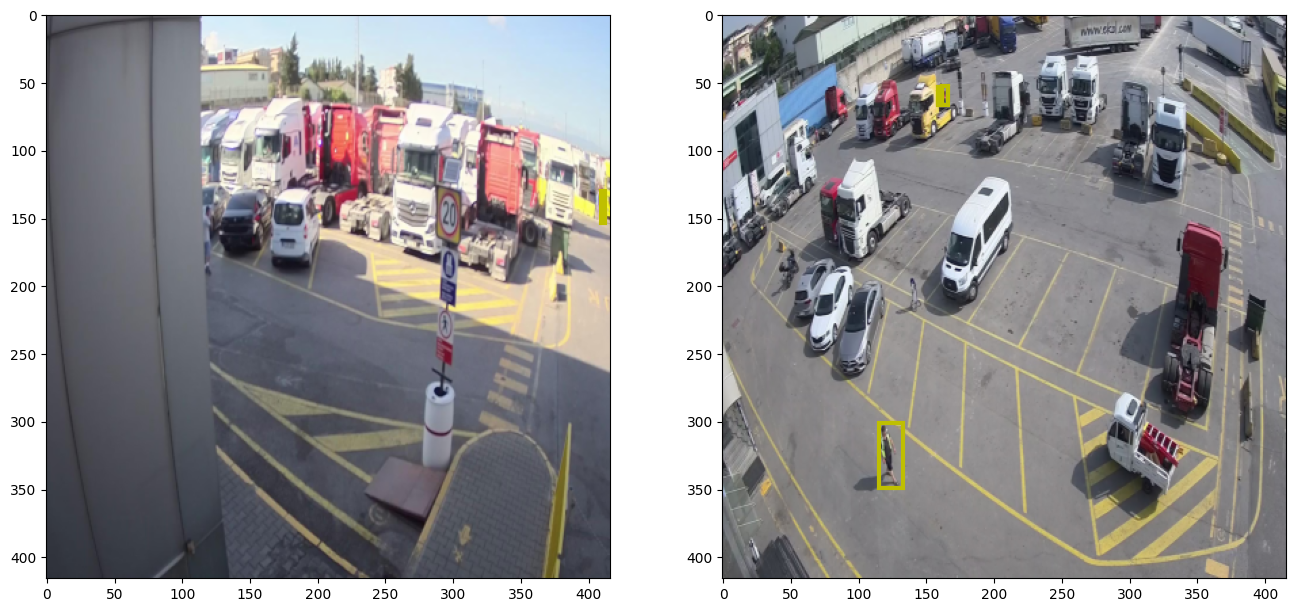

In [11]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

## Convolutional Backbone Network

We will use the first 4 layers of resnet50 as our convolutional backbone

In [12]:
model = torchvision.models.resnet50(pretrained=True)

/home/berhan/.pyenv/versions/3.11.7/envs/Faster_RCNN_Pytorch-berhan/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/berhan/.pyenv/versions/3.11.7/envs/Faster_RCNN_Pytorch-berhan/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [14]:
# unfreeze all the parameters
for param in backbone.named_parameters():
     param[1].requires_grad = True

In [15]:
# run the image through the backbone
out = backbone(img_data_all)

In [16]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [17]:
out_c, out_h, out_w

(2048, 13, 13)

#### Check how much the image has been down-scaled

In [18]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

### Visualize feature maps

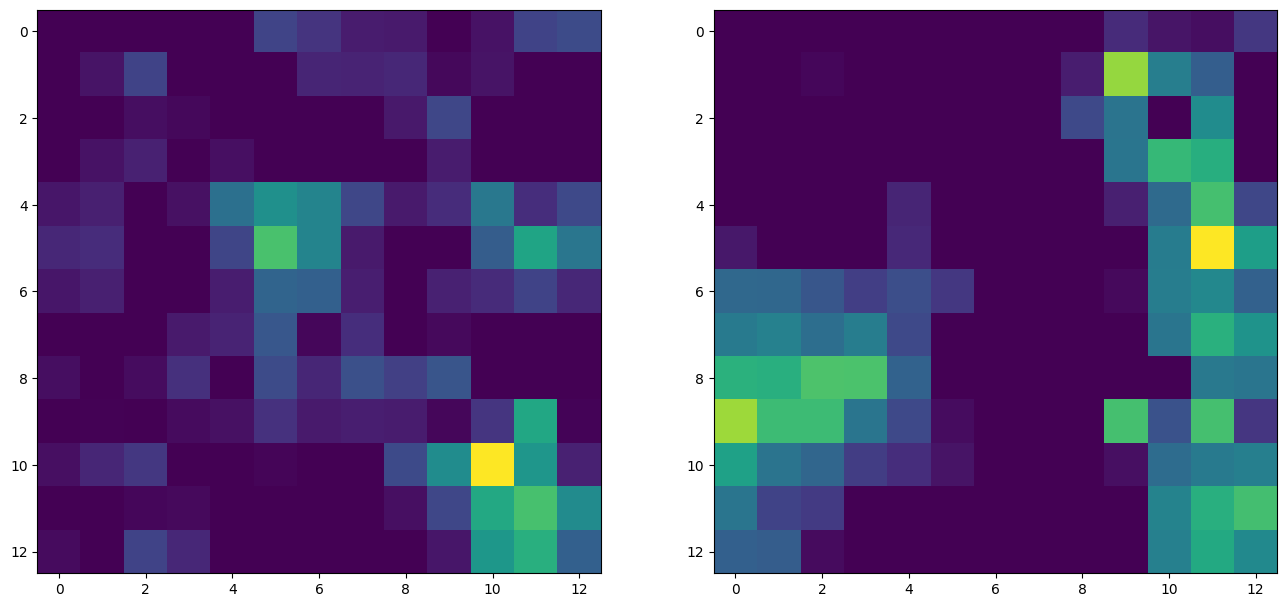

In [19]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [20]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

### Display Grid Mapping

In [21]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

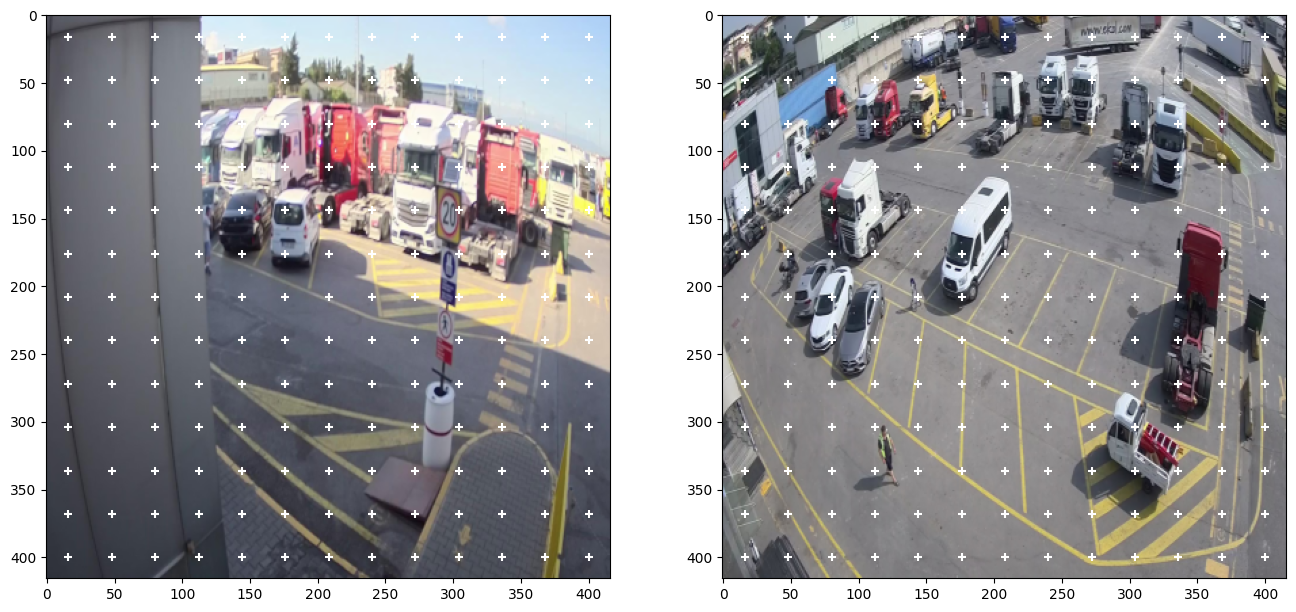

In [22]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

### Create Anchor Boxes around Anchor points

In [23]:
anc_scales = [2.1875, 4.40625, 8.84375]
#anc_scales = [4, 8, 16]
anc_ratios = [0.7267560533095297, 1, 1.375977531]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [24]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

/home/berhan/Desktop/Development-Berhan/Test_Workspace/Faster_R-CNN_PyToch/berhan_fasterrcnn_pytorch/utils.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/home/berhan/Desktop/Development-Berhan/Test_Workspace/Faster_R-CNN_PyToch/berhan_fasterrcnn_pytorch/utils.py:330: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

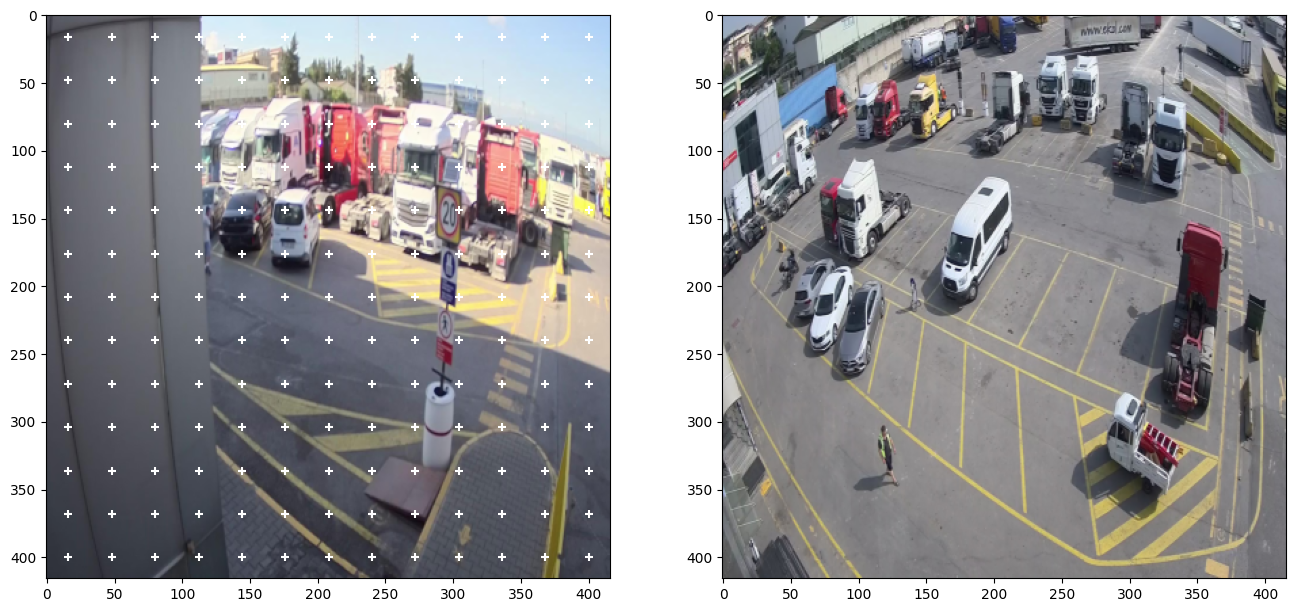

In [25]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

### plot all anchor boxes

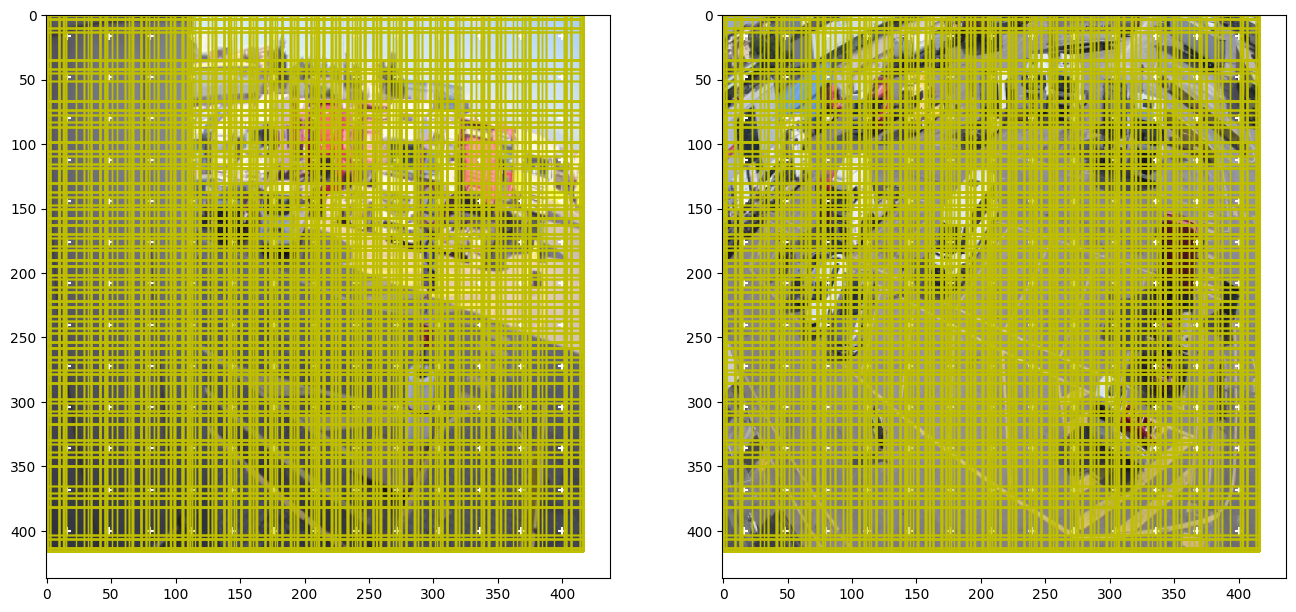

In [26]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [27]:
pos_thresh = 0.9
neg_thresh = 0.1

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [28]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

RuntimeError: shape '[2, 1, 53]' is invalid for input of size 0

#### Visualize positive anchor coordinates

In [172]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

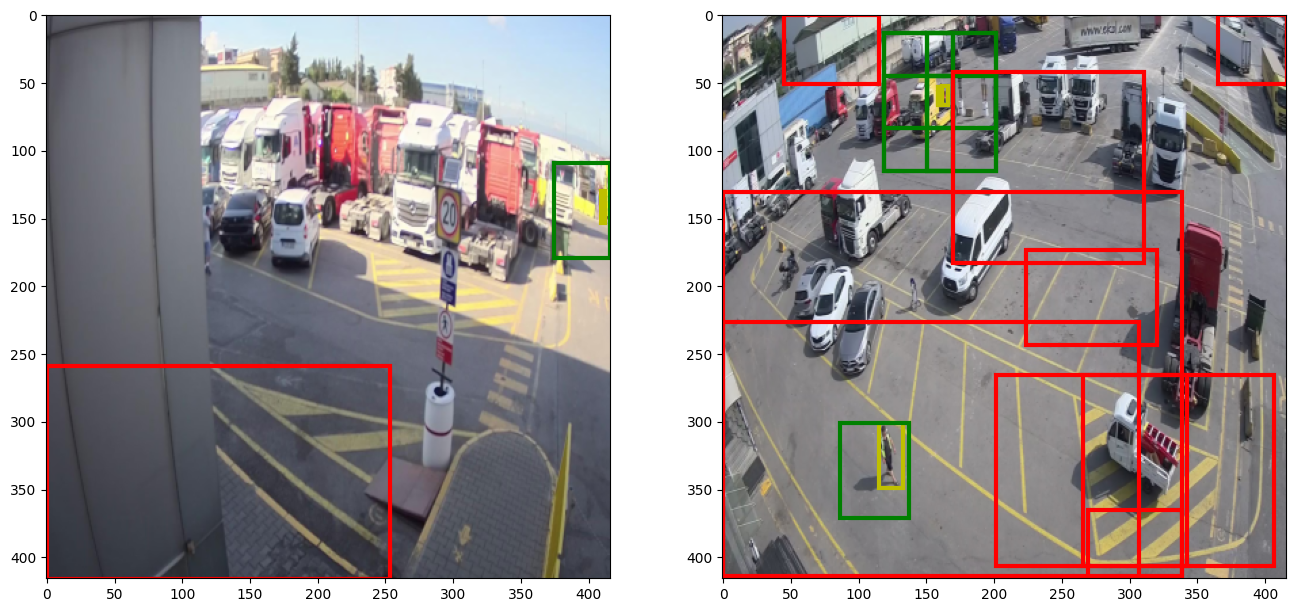

In [173]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

### Building the model

In [29]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [30]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

### Training loop

In [32]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_list.append(total_loss)
        
    return loss_list

In [33]:
learning_rate = 1e-3
n_epochs = 1000

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:28:53<00:00,  8.93s/it]


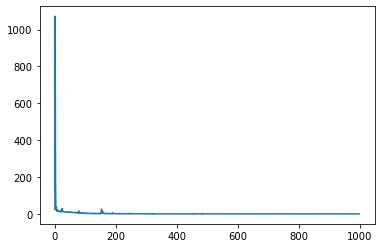

In [34]:
plt.plot(loss_list)

#### save model

In [35]:
torch.save(detector.state_dict(), "model.pt")

### Inference

In [36]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.99, nms_thresh=0.05)

In [37]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)